In [1]:
import csv
import nltk
import pickle
import string
import gensim
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.neural_network import MLPClassifier

In [2]:
path = '/home/arpan_aml/Project/dataset/'
stop_words = nltk.corpus.stopwords.words('english') + list(string.punctuation)
portStem = nltk.stem.PorterStemmer()

In [19]:
def clean_data(sentence):
    data = []
    sentence = word_tokenize(sentence)
    for token in sentence:
        if token not in stop_words:
            data.append(token)
    return data

### Reading training data

In [20]:
dataX = []
dataY = []
with open(path+'train.tsv', newline='', encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        dataY.append(int(row[0]))
        dataX.append([row[1], row[2]])
        
trainX = []
trainY = []
for ind in tqdm_notebook(range(len(dataX))):
    q0 = clean_data(dataX[ind][0])
    q1 = clean_data(dataX[ind][1])
    if len(q0) == 0 or len(q1) == 0:
        continue
    trainX.append([clean_data(dataX[ind][0]), clean_data(dataX[ind][1])])
    trainY.append(dataY[ind])

### Reading testing data

In [21]:
dataX = []
dataY = []
with open(path+'test.tsv', newline='', encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        dataY.append(int(row[0]))
        dataX.append([row[1], row[2]])
        
testX = []
testY = []
for ind in tqdm_notebook(range(len(dataX))):
    q0 = clean_data(dataX[ind][0])
    q1 = clean_data(dataX[ind][1])
    if len(q0) == 0 or len(q1) == 0:
        continue
    testX.append([clean_data(dataX[ind][0]), clean_data(dataX[ind][1])])
    testY.append(dataY[ind])

### Saving preprocessed data
- data is an dictionary which contains following keys
- trainX and testX is list of, where each item contains 2 lists of tokenized and preprocessed sentence of both the question
- trainY and testY is list of, where each item is either 0 or 1, indicating whether they are similar or not.

In [22]:
data = {}
data['testX'] = testX
data['testY'] = testY
data['trainX'] = trainX
data['trainY'] = trainY
with open(path+'dataset.pkl', 'wb') as fp:
    pickle.dump(data, fp)

### Loading the saved model

In [23]:
with open(path+'dataset.pkl', 'rb') as fp:
    data = pickle.load(fp)
trainX = data['trainX']
trainY = data['trainY']
testX = data['testX']
testY = data['testY']

### Creating wordcloud of the training dataset of top 2000 words

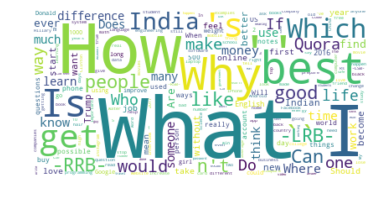

In [25]:
dataX = []
dataY = []
with open(path+'train.tsv', newline='', encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        dataY.append(int(row[0]))
        dataX.append([row[1], row[2]])


freq = {}
for i in tqdm_notebook(range(len(dataX))):
    t1 = dataX[i][0].split()
    t2 = dataX[i][1].split()
    for w in t1:
        if w in stop_words:
            continue
        if w not in freq:
            freq[w] = 0
        freq[w] += 1
    for w in t2:
        if w in stop_words:
            continue
        if w not in freq:
            freq[w] = 0
        freq[w] += 1

wc = WordCloud(background_color="white", max_words=2000, max_font_size=100)
wc.generate_from_frequencies(frequencies=freq)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
# plt.title('Word cloud of top 2000 words based on the frquency')
plt.show()

### Creating bargraph for top 100 words based on the frquency

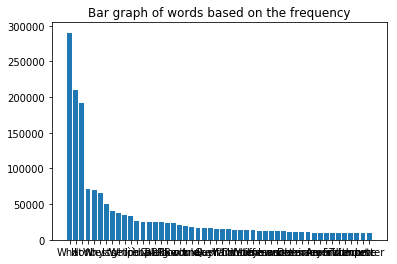

In [29]:
dataX = []
dataY = []
with open(path+'train.tsv', newline='', encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        dataY.append(int(row[0]))
        dataX.append([row[1], row[2]])


word_list = []
for i in tqdm_notebook(range(len(dataX))):
    t1 = dataX[i][0].split()
    t2 = dataX[i][1].split()
    for w in t1:
        if w in stop_words:
            continue
        word_list.append(w)
    for w in t2:
        if w in stop_words:
            continue
        word_list.append(w)

counts = Counter(word_list)
labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort[:50]]
values = np.array(values)[indSort[:50]]
indexes = np.arange(len(labels))
plt.bar(indexes, values)
plt.xticks(indexes , labels)
plt.title('Bar graph of words based on the frequency')
plt.show()

### Vectorize training dataset using word2vec

In [30]:
def sen2vec(word_list):
    vector = []
    word_list = [w.lower() for w in word_list if w.isalpha()]
    for w in word_list:
        try:
            vector.append(model[w])
        except:
            continue
    vector = np.array(vector)
    v = vector.sum(axis = 0)
    return v / np.sqrt((v ** 2).sum())

In [31]:
model = gensim.models.KeyedVectors.load_word2vec_format(path+'GoogleNews-vectors-negative300.bin.gz', binary=True)

In [32]:
def qstn_vectorization(dataX, dataY):
    qstn_v_1 = []
    qstn_v_2 = []
    for ind in tqdm_notebook(range(len(dataX))):
        qstn_v_1.append(sen2vec(dataX[ind][0]))
        qstn_v_2.append(sen2vec(dataX[ind][1]))
    qstn_v_1 = np.array(qstn_v_1)
    qstn_v_2 = np.array(qstn_v_2)
    print(qstn_v_1[0].shape)
    print(qstn_v_2[0].shape)
    cnt = 0
    q_1 = []
    q_2 = []
    Y = []
    for i in tqdm_notebook(range(len(qstn_v_1))):
        try:
            if qstn_v_1[i].shape[0] == 300 and qstn_v_2[i].shape[0] == 300:
                cnt += 1
            q_1.append(qstn_v_1[i])
            q_2.append(qstn_v_2[i])
            Y.append(trainY[i])
        except:
            continue
    print(cnt)
    q_1 = np.array(q_1)
    q_2 = np.array(q_2)
    print(q_1.shape, q_2.shape)
    X = np.concatenate((q_1, q_2), axis = 1)
    Y = np.array(Y)
    return X, Y

In [33]:
trainX, trainY = qstn_vectorization(trainX, trainY)
testX, testY = qstn_vectorization(testX, testY)
data = {}
data['trainX'] = trainX
data['trainY'] = trainY
data['testX'] = testX
data['testY'] = testY
with open(path+'dataset_doc2vec.pkl', 'wb') as fp:
    pickle.dump(data, fp)

/home/arpan_aml/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()



(300,)
(300,)



384297
(384297, 300) (384297, 300)



(300,)
(300,)



9999
(9999, 300) (9999, 300)


In [34]:
with open(path + 'dataset_doc2vec.pkl', 'rb') as fp:
    data = pickle.load(fp)
trainX = data['trainX']
trainY = data['trainY']
testX = data['testX']
testY = data['testY']

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(500, 300, 200, 100, 75, 50, 25, 10))

In [ ]:
clf.fit(trainX, trainY)

In [ ]:
clf.score(testX, testY)

In [ ]:
clf_svm = SVC()

In [ ]:
clf_svm.fit(trainX, trainY)

In [ ]:
clf.score(testX, testY)

In [6]:
with open(path+'dataset_doc2vec.pkl', 'rb') as fp:
    data = pickle.load(fp)
with open(path+'MLP_clf.pkl', 'rb') as fp:
    clf = pickle.load(fp)

In [7]:
print(clf.score(data['testX'], data['testY']))

0.7885788578857886
